* Added named entity recognition
* Moved model out

---

# Setup

##### Set Root Dir as CWD

In [1]:
import os

# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

D:\Documents\A_DIGIPEN\PersonalSVN\Fall22SVN\CS374\Project\cs374-project


##### Imports

In [2]:
import numpy as np
import pandas as pd

import spacy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Local
from src.preprocesser import ReviewPreprocessor
from src.model import ReviewClassifier

# Load

In [3]:
path = "data/yelp/reviews/"

In [4]:
%%time
# Load dev set (10% of total data) as train
train_all = pd.read_pickle(path + "train.xz")

CPU times: total: 35.6 s
Wall time: 35.8 s


In [5]:
%%time
# Load test set (10% of total data) as test
test_all = pd.read_pickle(path + "test.xz")

CPU times: total: 4.11 s
Wall time: 4.11 s


In [6]:
num_samples = (10_000, 10_000)

train = train_all.iloc[:num_samples[0]]
test = test_all.iloc[:num_samples[1]]

In [7]:
train

,text,stars
2903612,I like Wedding Belles for an odd reason. I set...,5
5050964,We had a great stay here. I felt like we got a...,5
1226557,"A unique place for sure, not your standard bre...",3
776083,This will be a short review on service and gri...,4
227582,Great barbershop. Super friendly staff. They a...,5
...,...,...
1004107,They informed us 2 hours before our flight was...,1
4423491,We bought tickets to see Big Freedia and Solan...,1
5618540,My first visit to Charley's. Celebrated my 30t...,4
1740756,This place is in a lane by itself. Basic menu ...,5


##### Save Target

In [8]:
# Save reviews stars from 0-4
y_train = tf.convert_to_tensor(train["stars"].values - 1)
y_test = tf.convert_to_tensor(test["stars"].values - 1)

# Preprocess

In [9]:
batch_size = 2000
n_processes = 4

maxlen = 200         # Number of words per review to consider
vocab_size = 20_000  # Size of vocabulary

##### Load from raw data

In [10]:
%%time
# Configure preprocessor
prep = ReviewPreprocessor(vocab_size, maxlen)

# Preprocess text
X_train_norm = prep.normalize(train["text"], batch_size, n_processes)
X_test_norm = prep.normalize(test["text"], batch_size, n_processes)

CPU times: total: 13.7 s
Wall time: 1min 3s


In [11]:
# Fit tokenizer
prep.fit_tokenizer(X_train_norm)

# Convert to tensor of padded sequences
X_train = prep.to_tensor(X_train_norm)
X_test = prep.to_tensor(X_test_norm)

##### View Before and After Preprocessing

In [28]:
print_idx = 2
print(test["text"].iloc[print_idx])
print("\n - - - - \n")
print(X_test_norm[print_idx], len(X_test_norm[print_idx]))
print("\n - - - - \n")
print(X_test[print_idx])

Overall very disappointing experience with Audi Kirkwood.  Bought a 2014 Audi from this dealership.  Immediately after sale experienced change in responsiveness from representatives.  Emails went weeks without answers that were before answered within 1 day.  Recently brought vehicle back for recall (side curtain airbag issue requiring inspection and fix).  When I bought the car the sales staff had 'lost' the card that allows them to fill the car with gas, so told me to ask for a tank next time I was in.  I did so.  The tank was not refilled.  I also mentioned a high-pitched whine it was making and was told they would look into it. When I picked up the car I was told they didn't look at that, without further explanation.  Lastly, my side airbag covers are now themselves covered in greasy handprints.  Not what one expects from a luxury car dealership.  I recommend steering clear of Audi Kirkwood.  My last car purchase was a VW within the Bommarito family, and I had only good experiences 

# Model

* Reference https://keras.io/examples/nlp/text_classification_with_transformer/

##### Create Model

In [13]:
# Hyperparameters
embed_dim = 32  # Attention output size
num_heads = 2   # Number of attention heads
ff_dims = [32]  # Hidden layer sizes in feed forward network inside transformer
reg = 1.0e-2
dropout = 0.25

# Model
model = ReviewClassifier(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout)

In [14]:
model.predict(X_train[:5])

1/1 [==============================] - 1s 1s/step


array([[0.31561735, 0.17757234, 0.17611957, 0.1404784 , 0.19021223],
       [0.34129784, 0.17768808, 0.17638513, 0.12888476, 0.17574422],
       [0.39458406, 0.18036665, 0.16014206, 0.10176486, 0.16314237],
       [0.32508677, 0.17838734, 0.17959638, 0.13709067, 0.17983888],
       [0.3928489 , 0.19898139, 0.15214801, 0.09555166, 0.16047004]],
      dtype=float32)

##### Compile and Run

In [15]:
learning_rate = 1e-3

model.compile(optimizer=keras.optimizers.Adam(learning_rate), 
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.build(X_train.shape)

In [16]:
model.summary()

Model: "review_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 t_emb (Embedding)           multiple                  640000    
                                                                 
 p_emb (Embedding)           multiple                  6400      
                                                                 
 attention (MultiHeadAttenti  multiple                 8416      
 on)                                                             
                                                                 
 sequential (Sequential)     (None, 200, 32)           1056      
                                                                 
 layer_normalization (LayerN  multiple                 64        
 ormalization)                                                   
                                                                 
 layer_normalization_1 (Laye  multiple           

In [17]:
%%time
# Train model
epochs = 10
cp_path = "refactor/model_checkpoints/"
cp_num = 2

# Early stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)

# Create a callback that saves the model's weights
checkpoint_dir = os.path.dirname(cp_path)
create_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=cp_path + f"refactor{cp_num}.ckpt", monitor="val_loss", verbose=1, save_best_only=True)

history = model.fit(
    X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_test, y_test),
    callbacks=[early_stopping, create_checkpoint], verbose=1,
)

Epoch 1/10
309/313 [============================>.] - ETA: 0s - loss: 1.5147 - accuracy: 0.5139
Epoch 1: val_loss improved from inf to 1.13117, saving model to refactor/model_checkpoints\refactor2.ckpt


INFO:tensorflow:Assets written to: refactor/model_checkpoints\refactor2.ckpt\assets


INFO:tensorflow:Assets written to: refactor/model_checkpoints\refactor2.ckpt\assets


313/313 [==============================] - 4s 11ms/step - loss: 1.5092 - accuracy: 0.5154 - val_loss: 1.1312 - val_accuracy: 0.6017
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 0.9751 - accuracy: 0.6508
Epoch 2: val_loss improved from 1.13117 to 0.95790, saving model to refactor/model_checkpoints\refactor2.ckpt


INFO:tensorflow:Assets written to: refactor/model_checkpoints\refactor2.ckpt\assets


INFO:tensorflow:Assets written to: refactor/model_checkpoints\refactor2.ckpt\assets


313/313 [==============================] - 3s 10ms/step - loss: 0.9751 - accuracy: 0.6508 - val_loss: 0.9579 - val_accuracy: 0.6381
Epoch 3/10
307/313 [============================>.] - ETA: 0s - loss: 0.7678 - accuracy: 0.7197
Epoch 3: val_loss did not improve from 0.95790
313/313 [==============================] - 2s 6ms/step - loss: 0.7676 - accuracy: 0.7199 - val_loss: 0.9632 - val_accuracy: 0.6377
Epoch 4/10
309/313 [============================>.] - ETA: 0s - loss: 0.6505 - accuracy: 0.7656
Epoch 4: val_loss did not improve from 0.95790
313/313 [==============================] - 2s 6ms/step - loss: 0.6515 - accuracy: 0.7650 - val_loss: 1.1079 - val_accuracy: 0.5892
CPU times: total: 14.4 s
Wall time: 11.2 s


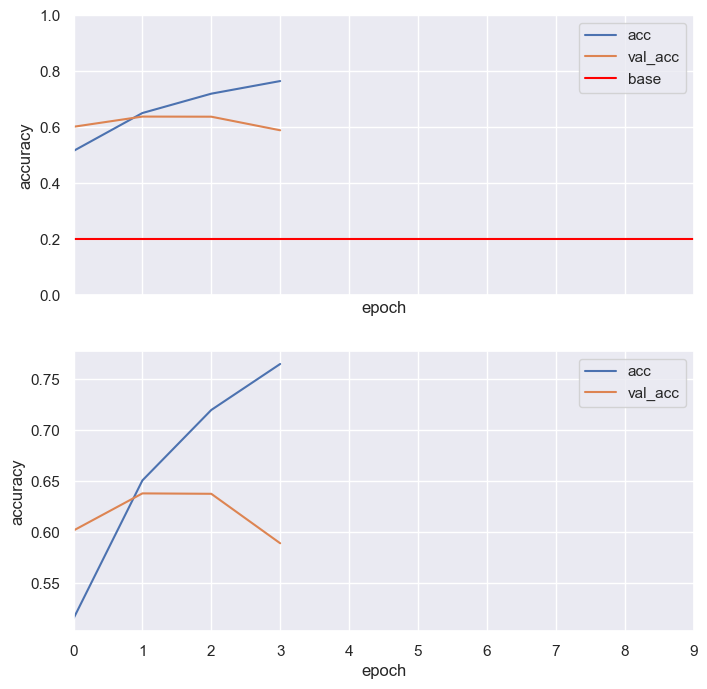

In [18]:
hist = history.history
acc, val_acc = hist["accuracy"], hist["val_accuracy"]

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8, 8), dpi=100)

for i, ax in enumerate(axes):
    ax.plot(acc, label="acc")
    ax.plot(val_acc, label="val_acc")
    
    ax.set_xlim(0, epochs - 1)
    if i == 0:
        ax.set_ylim(0.0, 1.0)
        ax.axhline(0.2, color="red", label="base")
        
    ax.grid(visible=True, axis="both")
    ax.legend()
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")

plt.show()

##### Evaluate

In [19]:
# Get probabilities per class
y_pred = model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [20]:
# Get star predictions and negative/positive predictions
y_pred_multi = tf.argmax(y_pred, axis=1)
y_pred_binary = y_pred_multi >= 3

In [21]:
print("multi-class accuracy: " + str((y_pred_multi == y_test).numpy().sum() / len(y_test)))
print("(compare to ~0.2)")

multi-class accuracy: 0.5892
(compare to ~0.2)


In [22]:
print("binary accuracy: " + str((y_pred_binary == (y_test >= 3)).numpy().sum() / len(y_test)))
print("(compare to ~0.5)")

binary accuracy: 0.869
(compare to ~0.5)


In [23]:
avg_err = tf.reduce_sum(tf.math.abs(y_test - y_pred_multi)) / len(y_test)
avg_err = avg_err.numpy()
print(f"Average of {avg_err:.4f} stars off")

Average of 0.5762 stars off


##### Visualize Attention

In [24]:
# Get attention scores
_, attns = model(X_test[:100], return_att=True)

# Get attention for each sample
attns = tf.reduce_mean(attns, axis=2)[:, 0, :]
attns

<tf.Tensor: shape=(100, 200), dtype=float32, numpy=
array([[0.02507712, 0.02497185, 0.025032  , ..., 0.        , 0.        ,
        0.        ],
       [0.03037049, 0.03027537, 0.0302392 , ..., 0.        , 0.        ,
        0.        ],
       [0.00787494, 0.00789784, 0.00786457, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.034612  , 0.03444517, 0.03446313, ..., 0.        , 0.        ,
        0.        ],
       [0.0323972 , 0.03223583, 0.03218741, ..., 0.        , 0.        ,
        0.        ],
       [0.01898231, 0.01885783, 0.01888425, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [25]:
attns[0][:34]

<tf.Tensor: shape=(34,), dtype=float32, numpy=
array([0.02507712, 0.02497185, 0.025032  , 0.02497309, 0.02505702,
       0.02495077, 0.02493994, 0.02495923, 0.02503428, 0.02499463,
       0.02501323, 0.02499906, 0.02498788, 0.02502233, 0.02499127,
       0.02501955, 0.02500923, 0.02498962, 0.02503584, 0.02495692,
       0.02499645, 0.02492891, 0.02496748, 0.02496054, 0.02504964,
       0.02499085, 0.02499859, 0.02503404, 0.02501472, 0.02503882,
       0.02500874, 0.02497837, 0.02502712, 0.02496772], dtype=float32)>

["'", 'm', 'frustrated', 'start', '4', 'e0', 'TIME', 'TIME', 'TIME', 'deal', 'loud', 'water', 'leak', 'awake', '.', "'", 's', 'ongoing', 'problem', "'", 've', 'deal', 'DATE', 'know', 'defective', 'pex', 'piping', 'ORG', 'ORG', 'repair', 'consultation', 'quote', 'replumb', ',', 'replace', 'repair', 'pipe', ',', 'duct', 'hvac', 'unit', ',', 'drywall', ',', 'floor', ',', 'mold', 'damage', 'result', 'defective', 'piping', '.', "'", 've', 'delay', 'delay', 'try', 'homeowner', 'insurance', 'quote', 'start', 'people', 'come', ',', "'", 't', 'simply', 'email', 'quote', '.', 'PERSON', 'day', ',', 'keep', 'want', 'trust', 'reuse', 'ORG', 'ORG', 'massive', 'undertaking', 'base', 'DATE', 'experience', ',', 'especially', 'commercial', 'property', '.', 'TIME', 'TIME', 'breaking', 'point', "'", 've', 'get', 'ton', 'email', 'follow', 'customer', 'service', 'tell', ',', '"', 'problem', ',', "'", 'll', 'send', 'field', 'manager', 'DATE', '.', '"', "'", 've', 'get', '.']
<Original Text>
I'm beyond frustr

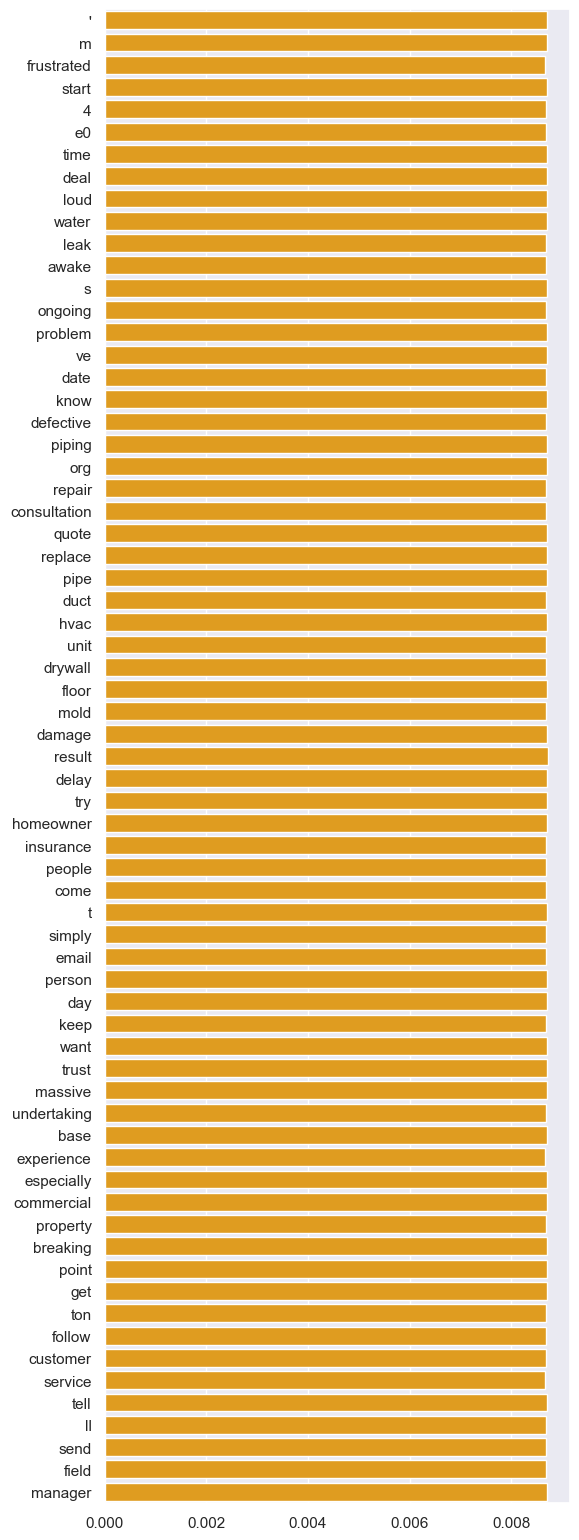

In [30]:
sample_idx = 3

# Get word sequences without oov words
in_seq = X_test_norm[sample_idx]
print(in_seq)
in_seq = [tok for tok in prep.tokenizer.sequences_to_texts(prep.tokenizer.texts_to_sequences(in_seq)) if tok]
seq_len = len(in_seq)

# Get attention values
attn_vals = attns[sample_idx][:seq_len].numpy()

print("<Original Text>")
print(test["text"].iloc[sample_idx])

print("\n<Preprocessed>")
print(in_seq)

plt.figure(figsize=(6, 0.2 * seq_len), dpi=100)
sns.barplot(y=in_seq, x=attn_vals, ci=None, color="orange")

plt.show()